In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df
from helpers import get_peaks_and_valleys
from helpers import plot_df
from helpers import get_num_reps
from helpers import smooth_and_resample
from helpers import segment_into_reps
from helpers import add_features

from tcn import TCN
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GRU
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  #"../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  #"../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  #"../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  #"../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  #"../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  #"../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  #"../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  #"../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                  "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                  "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  #"../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              #"../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              #"../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              #"../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              #"../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              #"../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              #"../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              #"../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              #"../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
max_len = 100

train_dfs = [add_features(create_df(f)) for f in training_files]
all_train_data = pd.concat(train_dfs, ignore_index=True)
feature_cols = all_train_data.columns.difference(['timestamp'])

global_mean = all_train_data[feature_cols].mean()
global_std = all_train_data[feature_cols].std()

for file, label in training_files.items():
    df = create_df(file)
    df = add_features(df)
    feature_cols = df.columns.difference(['timestamp'])
    df[feature_cols] = ((df[feature_cols] - global_mean) / global_std).fillna(0)
    #file_resampled = smooth_and_resample(df, target_len=1000)
    reps = segment_into_reps(df, min_rep_length=500, max_rep_length=5000)
    
    # For each rep in the training files, smooth & resample them, then append
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_train.append(rep_resampled)
        y_train.append(label)

# Iterate through each test file to add additional features and segment into reps
for file, label in test_files.items():
    df = create_df(file)
    df = add_features(df)
    feature_cols = df.columns.difference(['timestamp'])
    df[feature_cols] = ((df[feature_cols] - global_mean) / global_std).fillna(0)
    #file_resampled = smooth_and_resample(df, target_len=1000)
    reps = segment_into_reps(df, min_rep_length=500, max_rep_length=5000)
    
    # For each rep in the test files, smooth & resample them, then append
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_test.append(rep_resampled)
        y_test.append(label)

rep_lengths = [len(rep) for rep in X_train + X_test]
target_length = int(np.median(rep_lengths))

../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv
../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv
../data2/bicep_curl/bicep_jake_set1_reps10_1.csv
../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv
../data2/bicep_curl/bicep_mike_set1_reps10_1.csv
../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv
../data2/bicep_curl/bicep_udai_set1_reps10_1.csv
../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv
../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv
../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv
../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv
../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv
../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv
../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv
../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv
../data2/row/row_adam_set1_reps10_1.csv
../data2/row/row_andrew_set1_reps10_1.csv
../data2/row/row_anuj_set1_rep10_1.csv
../data2/row/row_jake_set1_rep

In [5]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    
    arr = df.drop('timestamp', axis=1).to_numpy()
    
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        pad_len = max_len - len(arr)
        pad = np.zeros((pad_len, len(arr[0])))
        return np.vstack((arr, pad))


max_len: 100


In [6]:
X_train = np.array([pad(df, target_length) for df in X_train])
X_test = np.array([pad(df, target_length) for df in X_test])

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

print(f"training_files.values(): {list(training_files.values())}")

num_classes = 4
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

training_files.values(): [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 2, 3, 3, 3]


In [7]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,124 (613.77 KB)

 Trainable params: 156,996 (613.27 KB)

 Non-trainable params: 128 (512.00 B)

In [8]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6655 - loss: 1.0396 - val_accuracy: 0.2881 - val_loss: 1.2592
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8258 - loss: 0.5724 - val_accuracy: 0.3220 - val_loss: 1.4062
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9268 - loss: 0.3234 - val_accuracy: 0.3390 - val_loss: 1.5499
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9408 - loss: 0.2082 - val_accuracy: 0.3898 - val_loss: 1.9641
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9512 - loss: 0.1780 - val_accuracy: 0.4407 - val_loss: 2.2712
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9721 - loss: 0.1174 - val_accuracy: 0.3729 - val_loss: 2.2369
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9652 - loss: 0.1183 - val_accuracy: 0.4407 - val_loss: 2.6132
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9861 - loss: 0.0551 - val_accuracy: 0.4576 - val_loss: 2.8911


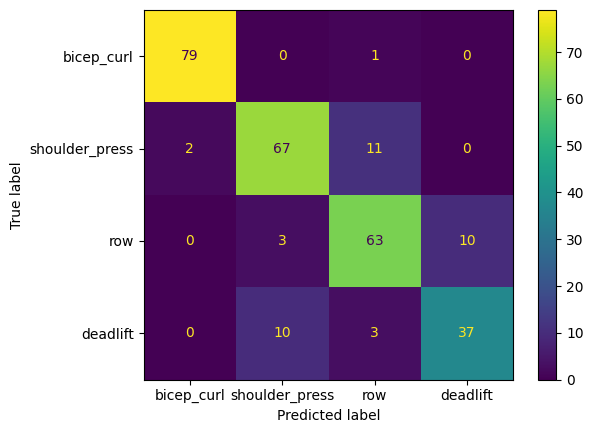

In [9]:
model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [10]:
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, kernel_size=7, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 94, 64)         │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,740 (706.02 KB)

 Trainable params: 179,844 (702.52 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7282 - loss: 0.6614 - val_accuracy: 0.4915 - val_loss: 1.2448
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9024 - loss: 0.2728 - val_accuracy: 0.4746 - val_loss: 1.1802
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9477 - loss: 0.1804 - val_accuracy: 0.5085 - val_loss: 1.1724
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9791 - loss: 0.1175 - val_accuracy: 0.4746 - val_loss: 1.2266
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9826 - loss: 0.0920 - val_accuracy: 0.4576 - val_loss: 1.2648
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9721 - loss: 0.0975 - val_accuracy: 0.4407 - val_loss: 1.2324
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9826 - loss: 0.0761 - val_accuracy: 0.4407 - val_loss: 1.4068
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9895 - loss: 0.0593 - val_accuracy: 0.4407 - val_loss: 1.4

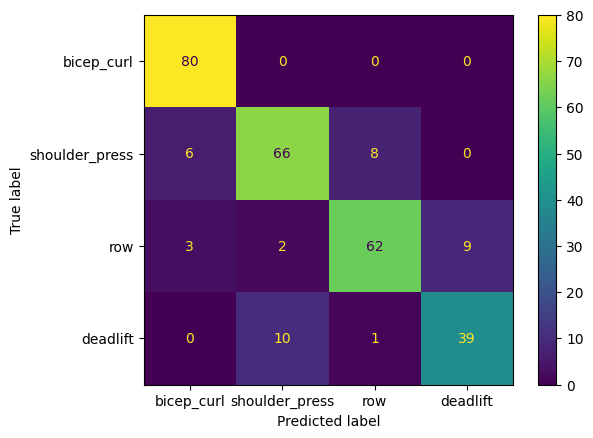

In [11]:
cnn_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# cnn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [12]:
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 96, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,980 (1.43 MB)

 Trainable params: 374,852 (1.43 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7456 - loss: 0.8423 - val_accuracy: 0.4576 - val_loss: 1.1930
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8955 - loss: 0.3257 - val_accuracy: 0.3729 - val_loss: 1.3712
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9756 - loss: 0.1548 - val_accuracy: 0.5085 - val_loss: 1.6520
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9791 - loss: 0.0865 - val_accuracy: 0.4576 - val_loss: 1.9717
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9930 - loss: 0.0436 - val_accuracy: 0.5424 - val_loss: 2.2024
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9930 - loss: 0.0324 - val_accuracy: 0.5593 - val_loss: 2.3030
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9930 - loss: 0.0218 - val_accuracy: 0.5424 - val_loss: 2.4892
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9930 - loss: 0.0205 - val_accuracy: 0.5593 - val_loss:

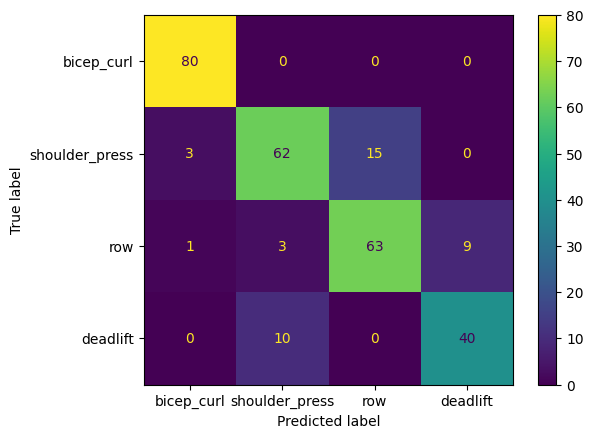

In [13]:
hybrid_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# hybrid_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(hybrid_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [14]:
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=64, kernel_size=5, dropout_rate=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tcn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       231,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,940 (937.27 KB)

 Trainable params: 239,940 (937.27 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
tcn_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2962 - loss: 4.5525 - val_accuracy: 0.2034 - val_loss: 1.8145
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4530 - loss: 1.5559 - val_accuracy: 0.4068 - val_loss: 1.2279
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5296 - loss: 1.1134 - val_accuracy: 0.4576 - val_loss: 1.1183
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6725 - loss: 0.7559 - val_accuracy: 0.3559 - val_loss: 1.2432
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7700 - loss: 0.5776 - val_accuracy: 0.4576 - val_loss: 1.0757
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7979 - loss: 0.4960 - val_accuracy: 0.4576 - val_loss: 1.2542
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8537 - loss: 0.4218 - val_accuracy: 0.4576 - val_loss: 1.2610
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8885 - loss: 0.3157 - val_accuracy: 0.4746 - val_loss: 1.3229


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
y_pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 2
 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 3 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
y_true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

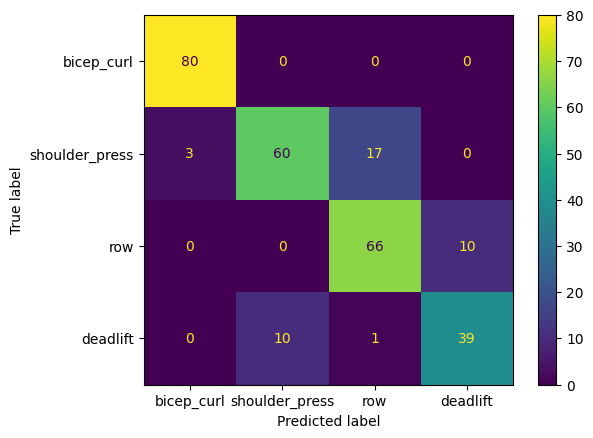

In [16]:
# tcn_model(np.zeros((1, X_train.shape[1], X_train.shape[2])))
# tcn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(tcn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [17]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(input_layer, input_layer)
x = LayerNormalization()(x)

x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

transformer_model = tf.keras.Model(input_layer, output)

transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 13)   │      7,053 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 13)   │         26 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 128)  │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        516 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,387 (36.67 KB)

 Trainable params: 9,387 (36.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4495 - loss: 1.1578 - val_accuracy: 0.3390 - val_loss: 1.4325
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7213 - loss: 0.7882 - val_accuracy: 0.3729 - val_loss: 1.2834
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7909 - loss: 0.5933 - val_accuracy: 0.3729 - val_loss: 1.2553
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7944 - loss: 0.4958 - val_accuracy: 0.4237 - val_loss: 1.2657
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8084 - loss: 0.4465 - val_accuracy: 0.4576 - val_loss: 1.2900
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8397 - loss: 0.3993 - val_accuracy: 0.4915 - val_loss: 1.3401
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8711 - loss: 0.3571 - val_accuracy: 0.4746 - val_loss: 1.4775
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8780 - loss: 0.3284 - val_accuracy: 0.4746 - val_loss: 1.5364


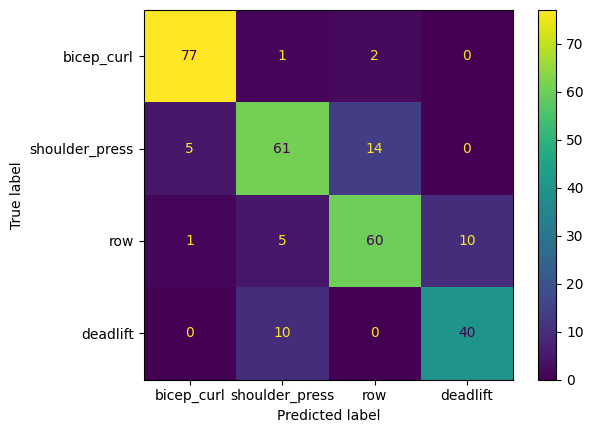

In [18]:
transformer_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# transformer_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(transformer_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [19]:
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    GRU(128, return_sequences=True),
    Dropout(0.3),

    GRU(64),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 128)       │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,580 (377.27 KB)

 Trainable params: 96,580 (377.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5331 - loss: 1.1617 - val_accuracy: 0.3220 - val_loss: 1.2475
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7108 - loss: 0.7691 - val_accuracy: 0.3390 - val_loss: 1.2288
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7735 - loss: 0.5636 - val_accuracy: 0.3898 - val_loss: 1.3159
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8537 - loss: 0.4339 - val_accuracy: 0.3729 - val_loss: 1.4571
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9059 - loss: 0.3161 - val_accuracy: 0.3220 - val_loss: 1.8901
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8990 - loss: 0.2770 - val_accuracy: 0.3559 - val_loss: 2.3411
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9199 - loss: 0.2260 - val_accuracy: 0.3729 - val_loss: 2.3639
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9477 - loss: 0.1538 - val_accuracy: 0.4237 - val_loss: 2.5176


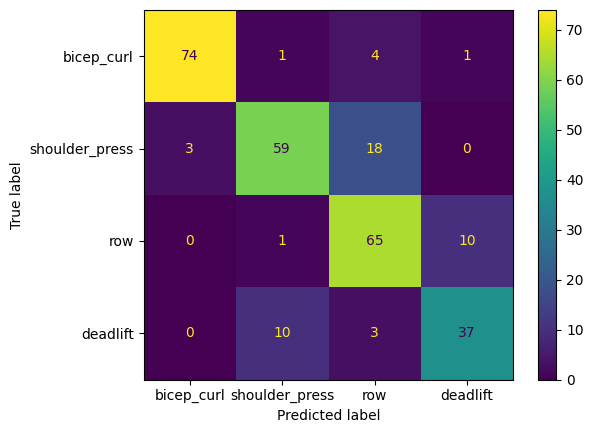

In [20]:
gru_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# gru_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(gru_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [21]:
from sklearn.model_selection import KFold

models = [model, cnn_model, hybrid_model, tcn_model, gru_model, transformer_model]
model_names = ["model", "cnn_model", "hybrid_model", "tcn_model", "gru_model", "transformer_model"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_accuracies = np.zeros(len(models))

X = X_train
y = y_train

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    for i, model in enumerate(models):
        # You need to re-initialize or clone models here if training from scratch
        # Or retrain your models if they require it, e.g. model.fit(X_train, y_train)
        
        # For demonstration, assuming models are already trained, just predict:
        val_pred_probs = model.predict(X_val)
        val_pred_labels = np.argmax(val_pred_probs, axis=1)
        y_val_labels = np.argmax(y_val, axis=1)
        
        acc = (val_pred_labels == y_val_labels).mean()
        val_accuracies[i] += acc

# Average accuracies across folds
val_accuracies /= kf.get_n_splits()

# Normalize to get weights
weights = val_accuracies / val_accuracies.sum()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best accuracy: 0.8846
Best model combination: ['model', 'cnn_model', 'tcn_model']
y_pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 2 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 2
 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
y_true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

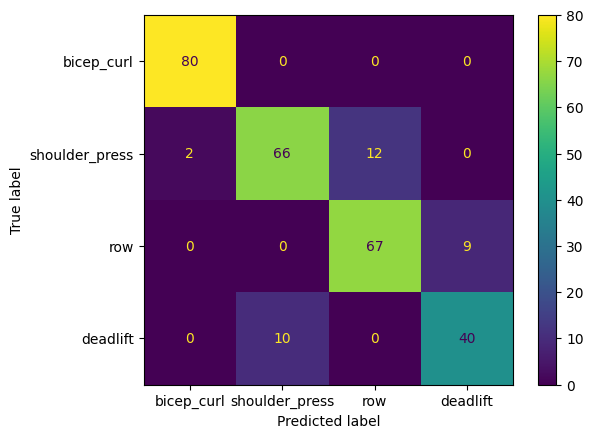

In [22]:
from itertools import combinations

# Ensemble method
# See if taking the average predictions of several models gives us a better result

best_acc = 0
best_combo = None
best_y_pred = None

# Get model predictions upfront
models = [model, cnn_model, hybrid_model, tcn_model, gru_model, transformer_model]
model_names = ["model", "cnn_model", "hybrid_model", "tcn_model", "gru_model", "transformer_model"]
all_preds = [m.predict(X_test) for m in models]
weighted_preds = [pred * weight for weight, pred in zip(weights, all_preds)]

# Iterate through every possible combination, excluding empty combination
for r in range(1, len(models)+1):
    for combo_indices in combinations(range(len(models)), r):

        # Get the average prediction across current ensemble of models
        preds_to_average = np.array([all_preds[i] for i in combo_indices])
        ensemble_preds = np.mean(preds_to_average, axis=0)

        # Get the best predictions
        y_pred = np.argmax(ensemble_preds, axis=1)
        y_true = np.argmax(y_test, axis=1)

        acc = accuracy_score(y_true, y_pred)

        # If we have a new highest accuracy, save that ensemble
        if acc > best_acc:
            best_acc = acc
            best_combo = combo_indices
            best_y_pred = y_pred

print(f"Best accuracy: {best_acc:.4f}")
print("Best model combination:", [model_names[i] for i in best_combo])

y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, best_y_pred)

print(f"y_pred: {best_y_pred}")
print(f"y_true: {y_true}")
print("Classification Report:\n", classification_report(y_true, best_y_pred))
print(cm)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()
